In [1]:
import torch
import dgl
from dgl.data import DGLDataset
import os
import pandas as pd
import re
import numpy as np
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from dgl.dataloading import GraphDataLoader
import torch.nn as nn
import dgl.nn as dglnn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from scipy.spatial import cKDTree 
from sklearn.model_selection import train_test_split
import math
import torchviz
from torchview import draw_graph
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import json
from dash import html
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
from matplotlib.colors import Normalize

# Constants for numerical stability
EPSILON = 1e-8
MAX_EXP = 20.0  # Prevent exponential explosion

In [2]:
def set_seed(seed=42):
    random.seed(seed) 
    np.random.seed(seed) 
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    dgl.seed(seed)

In [3]:
# Process molecular features and labels
class MolecularDataProcessor:
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.scaler = StandardScaler()
        
    def process_data(self):
        # Remove first column, extract features and target
        names = self.df['Sample Name'].values
        features = self.df.iloc[:, 1:-2].values  # Exclude first column, SMILES column and target column
        targets = self.df['target'].values
        smiles = self.df['smiles'].values
        
        # Standardize features
        features_scaled = self.scaler.fit_transform(features)
        
        return names, features_scaled, targets, smiles

In [4]:
def xyz_to_dataframe(file_path, frame=0, multi_frame=False):
    file_path = Path(file_path)
    if not file_path.exists(): 
        raise FileNotFoundError(f"XYZ file not found: {file_path}")
    
    with open(file_path, 'r') as f:
        lines = f.readlines() 

    if frame != 0:
        print("Single-frame file: ignoring frame parameter, reading first frame only")
    
    try:
        # Skip first two lines (atom count and title)
        data_lines = lines[2:]
        
        # Create DataFrame 
        df = pd.DataFrame([line.split() for line in data_lines if line.strip()],  
                          columns=['Element', 'X', 'Y', 'Z'])
        
        # Convert coordinate types 
        df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']].apply(pd.to_numeric,  errors='coerce')
        return df 
    
    except Exception as e:
        raise ValueError(f"Parsing error: {str(e)}") from e

In [5]:
def assign_to_nearest_atom(esp_df, atom_df):
    """Assign each electrostatic potential point to the nearest atom"""
    # Build KD-tree for atomic coordinates
    atom_coordinates = atom_df[['X', 'Y', 'Z']].values 
    atom_tree = cKDTree(atom_coordinates)
    
    # Query the nearest atom for each ESP point
    esp_coords = esp_df[['x', 'y', 'z']].values 
    distances, indices = atom_tree.query(esp_coords,  k=1)
    
    # Add results to ESP DataFrame
    esp_df['nearest_atom_idx'] = indices
    esp_df['nearest_atom_id'] = atom_df.iloc[indices]['AtomID'].values
    esp_df['nearest_atom_element'] = atom_df.iloc[indices]['Element'].values
    esp_df['nearest_atom_dist'] = distances 
    return esp_df

In [6]:
# Read electrostatic potential extremum point file
def parse_esp_file(file_path):
    """Parse ESP point file"""
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        minima_data = []
        maxima_data = []
        current_section = None

        for line in lines:
            line = line.strip()
            if line.startswith('Number of surface minima'):
                current_section = 'minima'
                continue
            elif line.startswith('Number of surface maxima'):
                current_section = 'maxima'
                continue
            elif line.startswith('#') or not line:
                continue

            parts = line.split()

            if parts and parts[0] == '*':
                parts = parts[1:]
            
            if len(parts) >= 7:
                try:
                    # Attempt to parse numerical data
                    x = float(parts[4])
                    y = float(parts[5])
                    z = float(parts[6])
                    esp = float(parts[3])
                    if current_section == 'minima':
                        minima_data.append([x, y, z, esp, 'min'])
                    elif current_section == 'maxima':
                        maxima_data.append([x, y, z, esp, 'max'])
                except ValueError:
                    continue

        # Combine data and create DataFrame
        esp_df = pd.DataFrame(minima_data + maxima_data, columns=['x', 'y', 'z', 'ESP', 'type'])
        return esp_df
        
    except Exception as e:
        print(f"Error parsing ESP extremum file: {str(e)}")
        return pd.DataFrame(columns=['x', 'y', 'z', 'ESP', 'type'])

In [7]:
def collate_fn(batch):
    """Custom collate function for processing graph data and molecular features"""
    graphs = [item['graph'] for item in batch]
    molecular_features = torch.stack([item['molecular_features'] for item in batch])
    targets = torch.stack([item['target'] for item in batch])
    file_ids = [item.get('file_id', '') for item in batch]
    
    batched_graph = dgl.batch(graphs)
    
    return {
        'batched_graph': batched_graph,
        'molecular_features': molecular_features,
        'target': targets,
        'file_id': file_ids
    }

In [8]:
class HybridMoleculeDataset(DGLDataset):
    def __init__(self, folder_path1, folder_path2, csv_path):
        self.folder_path1 = folder_path1   # Connectivity data
        self.folder_path2 = folder_path2   # Atomic features
        self.csv_path = csv_path           # Molecular features and labels
        self.global_max_points = 0  # Global maximum ESP point count
        
        # Process molecular features
        self.mol_processor = MolecularDataProcessor(csv_path)
        self.names, self.molecular_features, self.targets, self.smiles = self.mol_processor.process_data()
        
        # Create mapping from molecule ID to index
        self.mol_id_to_idx = {}
        for idx, name in enumerate(self.names):
            mol_id = str(name)
            self.mol_id_to_idx[mol_id] = idx
        
        super().__init__(name='hybrid_molecules')

    def _precompute_max_points(self):
        """Precompute global maximum ESP point count"""
        connectivity_files = [f for f in os.listdir(self.folder_path1) if f.endswith('.csv')]
        for filename in connectivity_files:
            file_id = filename.split('_connect_connectivity.csv')[0]
            try:
                # Read atomic coordinates
                atom_path = os.path.join("/home/yms/Python/Project_liuxinru/data/mol_data251224", file_id, f"{file_id}.xyz")
                if not os.path.exists(atom_path):
                    continue
                    
                atom_df = xyz_to_dataframe(atom_path)
                atom_df['AtomID'] = atom_df.index.astype(str) + '_' + atom_df['Element']
                
                # Read ESP extremum point file
                esp_path = os.path.join("/home/yms/Python/Project_liuxinru/data/mol_data_new", file_id, f"{file_id}_surfanalysis.txt")
                if not os.path.exists(esp_path):
                    continue
                
                esp_df = parse_esp_file(esp_path)
                if esp_df.empty:
                    continue
                    
                # Assign ESP points to nearest atoms
                esp_assigned = assign_to_nearest_atom(esp_df.copy(), atom_df)
                # Group by atom, count maximum points
                grouped = esp_assigned.groupby('nearest_atom_idx')
                for _, group in grouped:
                    num_points = len(group)
                    if num_points > self.global_max_points:
                        self.global_max_points = num_points
                        
            except Exception as e:
                print(f"Error processing file {file_id}: {str(e)}")
                continue
        print(f"Global maximum ESP point count: {self.global_max_points}")
        
    def process(self):
        self.graphs = []
        self.mol_features = []
        self.labels = []
        self.atom_dfs = []
        self.esp_dfs = []
        self.file_ids = []
        
        # Precompute maximum point count
        self._precompute_max_points()
        
        # Get all CSV files
        connectivity_files = [f for f in os.listdir(self.folder_path1) if f.endswith('.csv')]
        
        print("Processing molecular graphs and features...")
        processed_count = 0
        
        for i, filename in enumerate(connectivity_files):
            if i % 100 == 0:
                print(f"Processed {i}/{len(connectivity_files)} molecules")
                
            # Extract molecule ID
            file_id = filename.split('_connect_connectivity.csv')[0]
            
            # Check if corresponding molecular features exist
            if file_id not in self.mol_id_to_idx:
                for idx, name in enumerate(self.names):
                    if str(name) == file_id:
                        self.mol_id_to_idx[file_id] = idx
                        break
                else:
                    continue  # No matching molecular features found
            
            mol_idx = self.mol_id_to_idx[file_id]
            
            # 1. Read connectivity data
            conn_path = os.path.join(self.folder_path1, filename)
            df_conn = pd.read_csv(conn_path)
            
            if df_conn.empty:
                continue
            
            # 2. Read atomic properties
            prop_path = os.path.join(self.folder_path2, f"AtomProp_{file_id}.csv")
            if not os.path.exists(prop_path):
                print(f"Property file does not exist: {file_id}")
                continue
                
            df_prop = pd.read_csv(prop_path)
            
            # 3. Read atomic coordinates
            xyz_path = os.path.join("/home/yms/Python/Project_liuxinru/data/mol_data251224", file_id, f"{file_id}.xyz")
            atom_df = xyz_to_dataframe(xyz_path)
            atom_df['AtomID'] = atom_df.index.astype(str) + '_' + atom_df['Element']
                
            # 4. Read electrostatic potential extremum points
            esp_path = os.path.join("/home/yms/Python/Project_liuxinru/data/mol_data_new", file_id, f"{file_id}_surfanalysis.txt")
            if not os.path.exists(esp_path):
                continue

            esp_df = parse_esp_file(esp_path)
            if esp_df.empty:
                continue

            self.atom_dfs.append(atom_df)
            self.esp_dfs.append(esp_df)
            
            # 5. Assign ESP points to nearest atoms
            atom_coordinates = atom_df[['X', 'Y', 'Z']].values
            esp_coords = esp_df[['x', 'y', 'z']].values
            kdtree = cKDTree(atom_coordinates)
            distances, indices = kdtree.query(esp_coords)
            esp_df['nearest_atom_idx'] = indices  
            #['x','y','z','ESP','nearest_atom_idx']
            
            # 6. Build graph structure
            src_nodes = df_conn["Atom1"].str.extract(r'(\d+)', expand=False).astype(int) - 1
            dst_nodes = df_conn["Atom2"].str.extract(r'(\d+)', expand=False).astype(int) - 1
            
            # Create bidirectional graph (undirected graph)
            u = torch.cat([torch.tensor(src_nodes), torch.tensor(dst_nodes)])
            v = torch.cat([torch.tensor(dst_nodes), torch.tensor(src_nodes)])
            g = dgl.graph((u, v))
            
            # 7. Add node features
            atom_coordinates = torch.tensor(df_prop[["X", "Y", "Z"]].values, dtype=torch.float32)
            atom_ESP = torch.tensor(df_prop[["ESP All average (kcal/mol)"]].values, dtype=torch.float32)
            
            # 8. Add ESP point cloud data
            points_tensor = torch.full((len(atom_df), self.global_max_points, 5), -1.0, dtype=torch.float32)
            mask = torch.zeros((len(atom_df), self.global_max_points), dtype=torch.bool)
            # Group ESP points by atom
            grouped = esp_df.groupby('nearest_atom_idx')
            for atom_idx, group in grouped:
                if atom_idx >= len(atom_df):
                    continue
                num_points = min(len(group), self.global_max_points)
                atom_pos = atom_coordinates[atom_idx].numpy()
                
                for p_idx, (_, row) in enumerate(group.iterrows()):
                    esp_pos = np.array([row['x'], row['y'], row['z']])/0.529177
                    vector = esp_pos - atom_pos
                    distance = np.linalg.norm(vector)
                    
                    points_tensor[atom_idx, p_idx] = torch.tensor([
                        row['ESP'],
                        vector[0],
                        vector[1],
                        vector[2],
                        distance
                    ])
                    mask[atom_idx, p_idx] = True
                    
            if g.num_nodes() != len(atom_coordinates):
                print(f"Node count mismatch! {file_id}: graph nodes {g.num_nodes()} vs features {len(atom_coordinates)}")
                continue
                
            g.ndata["pos"] = atom_coordinates  # 3D coordinates
            g.ndata["feat"] = atom_ESP
            g.ndata['points'] = points_tensor
            g.ndata['points_mask'] = mask
            
            # Add self-loops
            g = dgl.add_self_loop(g)
            
            self.graphs.append(g)
            self.mol_features.append(self.molecular_features[mol_idx])
            self.labels.append(self.targets[mol_idx])
            self.file_ids.append(file_id)
            processed_count += 1
        
        self.mol_features = np.array(self.mol_features)
        self.labels = np.array(self.labels)
        print(f"Successfully processed {processed_count}/{len(connectivity_files)} molecules")
        print(f"all molecules names: {self.file_ids}")
    
    def __getitem__(self, i):
        return {
            'graph': self.graphs[i].clone(),
            'molecular_features': torch.tensor(self.mol_features[i], dtype=torch.float32),
            'target': torch.tensor(self.labels[i], dtype=torch.float32),
            'atom_df': self.atom_dfs[i] if i < len(self.atom_dfs) else None,
            'esp_df': self.esp_dfs[i] if i < len(self.esp_dfs) else None,
            'file_id': self.file_ids[i] if i < len(self.file_ids) else f"mol_{i}"
        }
    
    def __len__(self):
        return len(self.graphs)

In [9]:
class WeightedESPConvLayer(nn.Module):
    def __init__(self, S=5, gamma=1.0, hidden_dim=32, use_esp_weighting=True, use_spatial_weighting=True, node_feature_mode="concat", input_dim=None):
        super(WeightedESPConvLayer, self).__init__()
        self.S = S
        self.gamma = gamma
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim if input_dim is not None else hidden_dim
        self.use_esp_weighting = use_esp_weighting
        self.use_spatial_weighting = use_spatial_weighting
        self.node_feature_mode = node_feature_mode
        
        if self.node_feature_mode == "add":
            self.node_transform = nn.Sequential(
                nn.Linear(self.input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            
        # Learnable angular basis
        self.beta = nn.Parameter(torch.rand(S) * 2 * math.pi / S)  
        
        if self.node_feature_mode == "concat":
            f_input_dim = hidden_dim + 2
        else:  # add mode
            f_input_dim = 2
            
        self.f = nn.Sequential(
            nn.Linear(f_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        if use_esp_weighting:
            self.esp_weight = nn.Parameter(torch.tensor(0.1))
        
        if use_spatial_weighting:
            self.dist_weight = nn.Parameter(torch.tensor(0.1))
            self.dist_gamma = nn.Parameter(torch.tensor(1.0))
        
        self.init_weights()
                    
    def init_weights(self):
        if hasattr(self, 'node_transform'):
            for m in self.node_transform:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
                    
        for m in self.f: 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight) 
                nn.init.constant_(m.bias, 0)
        
        for m in self.output_proj:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight) 
                nn.init.constant_(m.bias, 0)
        
        with torch.no_grad():
            self.beta.uniform_(0, 2 * math.pi / self.S)

    def safe_exp(self, x):
        """Safe exponential calculation to prevent numerical overflow"""
        x = torch.clamp(x, -MAX_EXP, MAX_EXP)
        return torch.exp(x)
    
    def get_node_features(self, g):
        """Get node features"""
        if 'h_temp' in g.ndata:
            node_features = g.ndata['h_temp']  # [num_atoms, hidden_dim]
        else:
            node_features = g.ndata['feat']  # [num_atoms, atom_feat_dim]
            # If dimensions don't match, project
            if node_features.shape[1] != self.hidden_dim:
                node_features = torch.zeros(node_features.shape[0], self.hidden_dim, 
                                          device=node_features.device)
        return node_features

    def prepare_point_features(self, node_features, esp_values, distances):
        """Prepare point features according to different fusion modes"""
        num_atoms = node_features.shape[0]
        max_points = esp_values.shape[1]
        
        if self.node_feature_mode == "concat":
            # Expand node features to each point
            node_features_expanded = node_features.unsqueeze(1).expand(-1, max_points, -1)   # [num_atoms, max_points, hidden_dim]
            # Concatenate node features and ESP features
            point_input = torch.cat([
                node_features_expanded,
                torch.stack([esp_values, distances], dim=-1)
            ], dim=-1)   # [num_atoms, max_points, hidden_dim + 2]
            f_points = self.f(point_input)   # [num_atoms, max_points, hidden_dim]
            return f_points
            
        else:  # add mode
            # Transform node features
            h_node = self.node_transform(node_features)   # [num_atoms, hidden_dim]
            # Only use ESP features
            point_input = torch.stack([esp_values, distances], dim=-1)   # [num_atoms, max_points, 2]
            f_points = self.f(point_input)   # [num_atoms, max_points, hidden_dim]
            # Expand node features to point level
            h_node_expanded = h_node.unsqueeze(1).expand(-1, max_points, -1)   # [num_atoms, max_points, hidden_dim]
            # Fuse node features and point features
            fused_point_features = f_points + h_node_expanded   # [num_atoms, max_points, hidden_dim]
            return fused_point_features
        
        
    def forward(self, g, node_features=None):
        """
        Args:
            g: DGL graph
            node_features: Optional node features, if None, get from g
        """
        atom_pos = g.ndata['pos']   #[num_atoms, 3]
        points = g.ndata['points']   #[num_atoms, max_points, 5]
        mask = g.ndata['points_mask']   #[num_atoms, max_points]

        if node_features is None:
            node_features = self.get_node_features(g)
        
        num_atoms = atom_pos.shape[0]
        device = atom_pos.device
        max_points = points.shape[1]

        esp_values = points[..., 0]   # [num_atoms, max_points]
        vectors = points[..., 1:4]   # [num_atoms, max_points, 3]
        distances = points[..., 4]   # [num_atoms, max_points]
        
        # Prepare point features
        f_points = self.prepare_point_features(node_features, esp_values, distances)
        
        # Calculate actual 3D coordinates of points
        point_coords = atom_pos.unsqueeze(1) + vectors   # [num_atoms, max_points, 3]
        
        # Calculate spatial distances between points
        coord_diff = point_coords.unsqueeze(2) - point_coords.unsqueeze(1)   # [num_atoms, max_points, max_points, 3]
        spatial_distances = torch.norm(coord_diff, dim=-1)   # [num_atoms, max_points, max_points]
        
        # Exclude self-connections
        self_mask = torch.eye(max_points, device=device, dtype=torch.bool).unsqueeze(0)   #[1, max_points, max_points]
        spatial_distances = spatial_distances.masked_fill(self_mask, float(10000.0))   # [num_atoms, max_points, max_points]
        
        # Calculate angles between these point pairs
        vectors_norm = F.normalize(vectors, dim=-1)   # [num_atoms, max_points, 3]
        dot_products = torch.matmul(vectors_norm, vectors_norm.transpose(1, 2))   # [num_atoms, max_points, max_points]
        dot_products = torch.clamp(dot_products, -1.0, 1.0)   # [num_atoms, max_points, max_points]
        theta = torch.acos(dot_products)   # [num_atoms, max_points, max_points]
        
        # Create masks
        point_mask = mask.unsqueeze(1) & mask.unsqueeze(2)   # [num_atoms, max_points, max_points]
        full_mask = point_mask & (~self_mask)   # Exclude self-connections

        # Calculate angle differences and Gaussian weights
        angle_diff = self.beta.view(1, 1, 1, self.S) - theta.unsqueeze(-1)   # [num_atoms, max_points, max_points, S]
        exponent = -self.gamma * angle_diff**2
        gauss_weights_initial = self.safe_exp(exponent)   # [num_atoms, max_points, max_points, S]
        
        if self.use_esp_weighting:
            esp_matrix = esp_values.unsqueeze(1).expand(-1, max_points, -1)   # [num_atoms, max_points, max_points]
            esp_weights = torch.abs(esp_matrix).unsqueeze(-1)   # [num_atoms, max_points, max_points, 1]
            # esp_weights = torch.clamp(esp_weights, 0, 10)  # Prevent extreme values
            gauss_weights = gauss_weights_initial * (1.0 + self.esp_weight * esp_weights)   # [num_atoms, max_points, max_points, S]
        else:
            gauss_weights = gauss_weights_initial
            
        if self.use_spatial_weighting:
            dist_exponent = -self.dist_gamma * spatial_distances.unsqueeze(-1)
            dist_weights = self.safe_exp(dist_exponent)   # [num_atoms, max_points, max_points, 1]
            gauss_weights = gauss_weights * (1.0 + self.dist_weight * dist_weights)   # [num_atoms, max_points, max_points, S]
        
        mask_float = full_mask.unsqueeze(-1).float()
        gauss_weights = gauss_weights * mask_float + EPSILON  # Avoid complete zeros

        # Get all point pair features
        point_features_i = f_points.unsqueeze(1).expand(-1, max_points, -1, -1)   # [num_atoms, max_points, max_points, hidden_dim]
        point_features_j = f_points.unsqueeze(2).expand(-1, -1, max_points, -1)   # [num_atoms, max_points, max_points, hidden_dim]
        pair_features = point_features_i + point_features_j   # [num_atoms, max_points, max_points, hidden_dim]

        pair_features_expanded = pair_features.unsqueeze(-2).expand(-1, -1, -1, self.S, self.hidden_dim)   
        # [num_atoms, max_points, max_points, S, hidden_dim]        
        
        weighted_features = gauss_weights.unsqueeze(-1) * pair_features_expanded
        aggregated = weighted_features.sum(dim=[1, 2])   # [num_atoms, S, hidden_dim]
        aggregated = aggregated.mean(dim=1)   # [num_atoms, hidden_dim]
        
        output = self.output_proj(aggregated)   # [num_atoms, hidden_dim]
        
        return output

In [10]:
class WeightedHybridGCNModel(nn.Module):
    def __init__(self, atom_feature_dim, molecular_feature_dim, hidden_dim=128, num_esp_layers=2, S=5, gamma=1.0, dropout=0.3):
        super(WeightedHybridGCNModel, self).__init__()
        
        self.num_esp_layers = num_esp_layers
        self.dropout = dropout
        
         # First layer
        self.esp_conv1 = WeightedESPConvLayer(S=S, gamma=gamma, hidden_dim=hidden_dim, node_feature_mode="concat")
        
        # Second layer
        self.esp_graph_convs = nn.ModuleList()
        for i in range(num_esp_layers):
            if i == 0:
                # input dimension: atomic features dimension+ first layer ESP features dimension
                input_dim = atom_feature_dim + hidden_dim
            else:
                input_dim = hidden_dim
            self.esp_graph_convs.append(
                WeightedESPConvLayer(input_dim=input_dim, hidden_dim=hidden_dim, S=S, gamma=gamma, node_feature_mode="add")
            )
        
        # Molecular feature processing
        self.molecular_feature_processor = nn.Sequential(
            nn.Linear(molecular_feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Graph feature processing
        self.graph_processor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Fusion and prediction layers
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, g, molecular_features):
        # g: DGL graph
        # molecular_features: [batch_size, molecular_feature_dim]

        esp_features1 = self.esp_conv1(g)
        
        h = torch.cat([g.ndata['feat'], esp_features1], dim=1)   # [num_atoms, atom_feature_dim + hidden_dim]
        
        for i, esp_graph_conv in enumerate(self.esp_graph_convs):
            h = esp_graph_conv(g, h)
            if i < len(self.esp_graph_convs) - 1:
                h = torch.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        with g.local_scope():
            g.ndata['h'] = h
            graph_embedding = dgl.mean_nodes(g, 'h')  # [batch_size, hidden_dim]
        
        graph_features = self.graph_processor(graph_embedding)
        
        mol_features = self.molecular_feature_processor(molecular_features)
        
        combined_features = torch.cat([graph_features, mol_features], dim=1)
        
        output = self.fusion_layer(combined_features)
        
        return output.squeeze(-1), combined_features

In [11]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in dataloader:
        batched_graph = batch['batched_graph'].to(device)
        molecular_features = batch['molecular_features'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, combined_features = model(batched_graph, molecular_features)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

In [12]:
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    actuals = []
    combined_features_list = []
    file_ids_list = []
    
    with torch.no_grad():
        for batch in dataloader:
            batched_graph = batch['batched_graph'].to(device)
            molecular_features = batch['molecular_features'].to(device)
            targets = batch['target'].to(device)
            
            outputs, combined_features = model(batched_graph, molecular_features)
            
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

            combined_features_list.append(combined_features.cpu().numpy())
            if 'file_id' in batch:
                file_ids_list.extend(batch['file_id'])
    
    if combined_features_list:
        combined_features_all = np.vstack(combined_features_list)
        return np.array(predictions), np.array(actuals), combined_features_all, file_ids_list

In [13]:
def plot_test_results(y_true, y_pred, metrics, save_path='test_set_scatter.png'):
    """Plot true vs predicted values scatter plot for test set"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Scatter plot
    ax1 = axes[0]
    
    scatter = ax1.scatter(y_true, y_pred, alpha=0.7, s=60, 
                         c=np.abs(y_true - y_pred),
                         cmap='viridis', edgecolor='black', linewidth=0.5)
    
    # Plot y=x reference line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    margin = (max_val - min_val) * 0.1
    x_limits = [min_val - margin, max_val + margin]
    y_limits = [min_val - margin, max_val + margin]
    
    ax1.plot(x_limits, x_limits, 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate regression line
    if len(y_true) > 1:
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
        reg_line = slope * np.array(x_limits) + intercept
        ax1.plot(x_limits, reg_line, 'g-', lw=2, alpha=0.7, label='Regression Line')
    
    ax1.set_xlabel('True Values', fontsize=12)
    ax1.set_ylabel('Predicted Values', fontsize=12)
    # ax1.set_title('Test Set: True vs Predicted Values', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend()
    ax1.set_xlim(x_limits)
    ax1.set_ylim(y_limits)
    
    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Absolute Error', fontsize=10)
    
    metrics_text = (f'R² = {metrics["r2"]:.4f}\n'
                    f'RMSE = {metrics["rmse"]:.4f}\n'
                    f'MAE = {metrics["mae"]:.4f}\n'
                    f'MSE = {metrics["mse"]:.4f}')
    
    ax1.text(0.95, 0.05, metrics_text,
            transform=ax1.transAxes,
            fontsize=11,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    # Right: Error distribution histogram
    ax2 = axes[1]
    
    errors = y_true - y_pred
    ax2.hist(errors, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add vertical lines for mean and standard deviation
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    ax2.axvline(mean_error, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_error:.3f}')
    ax2.axvline(mean_error + std_error, color='orange', linestyle=':', linewidth=2,
                label=f'±1 std: {std_error:.3f}')
    ax2.axvline(mean_error - std_error, color='orange', linestyle=':', linewidth=2)
    
    ax2.set_xlabel('Prediction Error (True - Predicted)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    # ax2.set_title('Error Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.legend()
    
    # Add normal distribution fit line
    from scipy.stats import norm
    x_hist = np.linspace(min(errors), max(errors), 100)
    ax2.plot(x_hist, norm.pdf(x_hist, mean_error, std_error) * len(errors) * (max(errors)-min(errors))/20, 
             'r-', lw=2, alpha=0.7, label='Normal Fit')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

Using device: cuda
Loading and processing data...
Global maximum ESP point count: 8
Processing molecular graphs and features...
Processed 0/774 molecules
Processed 100/774 molecules
Processed 200/774 molecules
Processed 300/774 molecules
Processed 400/774 molecules
Processed 500/774 molecules
Processed 600/774 molecules
Processed 700/774 molecules
Successfully processed 774/774 molecules
all molecules names: ['5a_S_bp1', '6i_S_bp4', '2a_R_bp4', '3i_R_bp3', '4a_R_Me_R_bp4', '2i_S_bp5', '5e_R_bp3', '6i_S_bp2', '3d_S_bp2', '5c_R_bp2', '1i_S_bp5', '3a_R_Me_R_bp2', '5h_R_bp4', '2h_S_bp2', '2j_R_bp2', '7j_R_bp3', '5i_S_bp1', '5d_S_bp2', '7j_S_bp4', '2i_R_Me_R_bp5', '6f_R_bp2', '2c_R_bp1', '1c_R_bp1', '5g_R_bp1', '1a_R_bp5', '1a_R_bp1', '2h_R_bp3', '1d_S_bp3', '5i_R_Me_S_bp4', '6d_S_bp1', '5g_S_bp5', '5a_R_bp3', '6g_R_bp3', '4g_R_bp5', '2a_S_bp3', '3b_R_Me_R_bp4', '5i_R_bp5', '5e_R_bp1', '1i_S_bp3', '5g_R_bp2', '4i_S_bp1', '1d_S_bp1', '3d_S_bp1', '2j_R_bp1', '4i_R_bp2', '2c_R_bp3', '3e_R_Me_S

/tmp/ipykernel_895735/2385716389.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))


Epoch 20/1000
  Train Loss: 2.7809
  Val Loss: 5.7621
  Val R²: 0.0813
Epoch 40/1000
  Train Loss: 2.2665
  Val Loss: 2.4986
  Val R²: 0.6016
Epoch 60/1000
  Train Loss: 1.9413
  Val Loss: 2.5492
  Val R²: 0.5936
Epoch 80/1000
  Train Loss: 1.4510
  Val Loss: 1.9549
  Val R²: 0.6883
Epoch 100/1000
  Train Loss: 1.2757
  Val Loss: 1.6778
  Val R²: 0.7325
Epoch 120/1000
  Train Loss: 1.1532
  Val Loss: 1.7579
  Val R²: 0.7197
Epoch 140/1000
  Train Loss: 1.1430
  Val Loss: 1.5745
  Val R²: 0.7490
Epoch 160/1000
  Train Loss: 1.0667
  Val Loss: 1.5143
  Val R²: 0.7586
Epoch 180/1000
  Train Loss: 1.0422
  Val Loss: 1.6914
  Val R²: 0.7303
Epoch 200/1000
  Train Loss: 0.9764
  Val Loss: 1.6895
  Val R²: 0.7306
Early stopping at epoch 214

Fold 2 Results:
  MSE:  1.4235
  RMSE: 1.1931
  MAE:  0.6682
  R²:   0.7730

Fold 3/5
--------------------------------------------------


/tmp/ipykernel_895735/2385716389.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))


Epoch 20/1000
  Train Loss: 3.1682
  Val Loss: 2.2007
  Val R²: 0.5983
Epoch 40/1000
  Train Loss: 2.0916
  Val Loss: 2.5105
  Val R²: 0.5418
Epoch 60/1000
  Train Loss: 1.6683
  Val Loss: 2.1378
  Val R²: 0.6098
Epoch 80/1000
  Train Loss: 1.3093
  Val Loss: 1.8109
  Val R²: 0.6695
Epoch 100/1000
  Train Loss: 1.3387
  Val Loss: 1.5468
  Val R²: 0.7177
Epoch 120/1000
  Train Loss: 1.3442
  Val Loss: 1.7025
  Val R²: 0.6893
Epoch 140/1000
  Train Loss: 1.2061
  Val Loss: 1.7201
  Val R²: 0.6860
Epoch 160/1000
  Train Loss: 1.2882
  Val Loss: 1.8097
  Val R²: 0.6697
Early stopping at epoch 165

Fold 3 Results:
  MSE:  1.4876
  RMSE: 1.2197
  MAE:  0.7159
  R²:   0.7285

Fold 4/5
--------------------------------------------------


/tmp/ipykernel_895735/2385716389.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))


Epoch 20/1000
  Train Loss: 2.9766
  Val Loss: 7.1417
  Val R²: -0.7201
Epoch 40/1000
  Train Loss: 2.1879
  Val Loss: 1.6783
  Val R²: 0.5958
Epoch 60/1000
  Train Loss: 1.7572
  Val Loss: 1.5854
  Val R²: 0.6182
Epoch 80/1000
  Train Loss: 1.7442
  Val Loss: 1.3463
  Val R²: 0.6757
Epoch 100/1000
  Train Loss: 1.4735
  Val Loss: 1.4526
  Val R²: 0.6502
Epoch 120/1000
  Train Loss: 1.4139
  Val Loss: 1.3299
  Val R²: 0.6797
Epoch 140/1000
  Train Loss: 0.9429
  Val Loss: 1.4286
  Val R²: 0.6559
Early stopping at epoch 143

Fold 4 Results:
  MSE:  1.0745
  RMSE: 1.0366
  MAE:  0.6694
  R²:   0.7412

Fold 5/5
--------------------------------------------------


/tmp/ipykernel_895735/2385716389.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))


Epoch 20/1000
  Train Loss: 2.2642
  Val Loss: 2.0280
  Val R²: 0.4732
Epoch 40/1000
  Train Loss: 2.1581
  Val Loss: 0.8101
  Val R²: 0.7896
Epoch 60/1000
  Train Loss: 1.8242
  Val Loss: 1.9356
  Val R²: 0.4972
Epoch 80/1000
  Train Loss: 1.5785
  Val Loss: 0.8529
  Val R²: 0.7784
Epoch 100/1000
  Train Loss: 1.2905
  Val Loss: 0.9166
  Val R²: 0.7619
Epoch 120/1000
  Train Loss: 1.0921
  Val Loss: 1.0820
  Val R²: 0.7189
Early stopping at epoch 139

Fold 5 Results:
  MSE:  0.7994
  RMSE: 0.8941
  MAE:  0.5577
  R²:   0.7923

TRAINING FINAL MODEL ON FULL TRAIN-VAL SET


/tmp/ipykernel_895735/2385716389.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))


Epoch 20/1000
  Train Loss: 3.2739
Epoch 40/1000
  Train Loss: 2.1373
Epoch 60/1000
  Train Loss: 1.9385
Epoch 80/1000
  Train Loss: 1.8554
Epoch 100/1000
  Train Loss: 1.6178
Epoch 120/1000
  Train Loss: 1.5477
Epoch 140/1000
  Train Loss: 1.3256
Epoch 160/1000
  Train Loss: 1.3085
Epoch 180/1000
  Train Loss: 1.1909
Epoch 200/1000
  Train Loss: 0.9384
Epoch 220/1000
  Train Loss: 1.1241
Epoch 240/1000
  Train Loss: 0.7745
Epoch 260/1000
  Train Loss: 0.6750
Epoch 280/1000
  Train Loss: 0.7018
Epoch 300/1000
  Train Loss: 0.9143
Early stopping at epoch 310

TEST SET RESULTS:
  MSE:  0.9411
  RMSE: 0.9701
  MAE:  0.5012
  R²:   0.7940

GENERATING TEST SET SCATTER PLOT


/tmp/ipykernel_895735/2385716389.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_final_model.pth'))


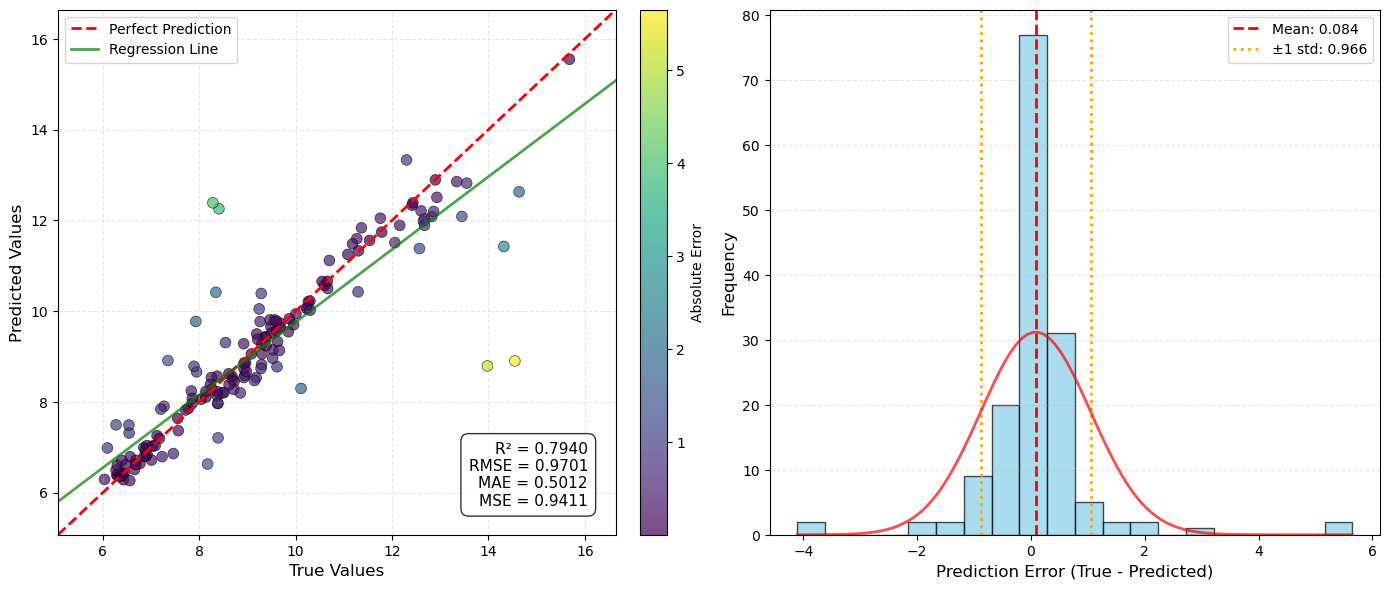


CROSS-VALIDATION RESULTS
 MSE: 1.2162 ± 0.2517
RMSE: 1.0964 ± 0.1190
 MAE: 0.6570 ± 0.0527
  R2: 0.7419 ± 0.0406


In [14]:
def main():
    set_seed(123)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set parameters
    batch_size = 32
    learning_rate = 0.005
    hidden_dim = 64
    S = 3 # Number of angular basis
    gamma = 0.8
    num_epochs = 1000
    patience = 50
    n_splits = 5
    dropout = 0.1
    weight_decay = 1e-5
    
    # Create dataset
    print("Loading and processing data...")
    dataset = HybridMoleculeDataset(
        folder_path1='/home/yms/Python/Project_liuxinru/data/connectivity_csv',
        folder_path2='/home/yms/Python/Project_liuxinru/data/250911_cal/Surfacia_3.0_20250916_135842',
        csv_path='/home/yms/Python/Project_liuxinru/data/FinalFull_Mode3_774_85.csv'
    )
    
    print(f"Total samples: {len(dataset)}")
    
    # Get feature dimensions
    sample = dataset[0]
    atom_feature_dim = sample['graph'].ndata['feat'].shape[1]  # Atomic feature dimension
    molecular_feature_dim = sample['molecular_features'].shape[0]  # Molecular feature dimension
    
    print(f"Atom feature dimension: {atom_feature_dim}")
    print(f"Molecular feature dimension: {molecular_feature_dim}")
    
    # Step 1: Split test set (20%) and train-validation set (80%)
    indices = np.arange(len(dataset))
    train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=123)
    
    test_molecule_ids = [dataset.file_ids[i] for i in test_idx]
    np.save('AEPNet_test_molecule_ids.npy', test_molecule_ids)
    
    # Create test set
    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )
    
    print(f"len of train&val set: {len(train_val_idx)}, len of test set: {len(test_idx)}")
    print(f"test molecules names: {test_molecule_ids}")
    
    # Save processed molecule IDs and test set split (for comparison with other models)
    np.save('AEPNet_valid_molecule_ids.npy', dataset.file_ids)
    np.save('AEPNet_test_indices.npy', test_idx)
    
    # Step 2: Perform 5-fold cross-validation on the train-validation set
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    fold_results = []
    y_true_all = []
    y_pred_all = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_idx)):
        print(f"\nFold {fold + 1}/5")
        print("-" * 50)
        
        # Create training and validation sets
        train_dataset = torch.utils.data.Subset(dataset, [train_val_idx[i] for i in train_idx])
        val_dataset = torch.utils.data.Subset(dataset, [train_val_idx[i] for i in val_idx])
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
        )
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
        )
        
        # Create model
        model = WeightedHybridGCNModel(
            atom_feature_dim=atom_feature_dim,
            molecular_feature_dim=molecular_feature_dim,
            hidden_dim=hidden_dim,
            num_esp_layers=1,
            S=S,
            gamma=gamma,
            dropout=dropout
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=20
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        val_r2_scores = []
        
        for epoch in range(num_epochs):
            # Training
            train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
            train_losses.append(train_loss)
            
            # Validation
            val_pred, val_true, combined_features_all, file_ids_list = evaluate_model(model, val_loader, device)
            val_loss = mean_squared_error(val_true, val_pred)
            val_r2 = r2_score(val_true, val_pred)
            
            val_losses.append(val_loss)
            val_r2_scores.append(val_r2)
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_hybrid_model_fold_{fold + 1}.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}")
                print(f"  Train Loss: {train_loss:.4f}")
                print(f"  Val Loss: {val_loss:.4f}")
                print(f"  Val R²: {val_r2:.4f}")
        
        # Load best model and evaluate
        model.load_state_dict(torch.load(f'best_hybrid_model_fold_{fold + 1}.pth'))
        y_pred, y_true, val_features, val_file_ids = evaluate_model(model, val_loader, device)
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        fold_result = {
            'fold': fold + 1,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        fold_results.append(fold_result)
        y_true_all.append(y_true)
        y_pred_all.append(y_pred)
        
        print(f"\nFold {fold + 1} Results:")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
    
    # Step 3: Train final model on entire train-validation set and evaluate on test set
    print("\n" + "="*60)
    print("TRAINING FINAL MODEL ON FULL TRAIN-VAL SET")
    print("="*60)
    
    train_val_dataset = torch.utils.data.Subset(dataset, train_val_idx)
    train_val_loader = torch.utils.data.DataLoader(
        train_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )
    
    final_model = WeightedHybridGCNModel(
        atom_feature_dim=atom_feature_dim,
        molecular_feature_dim=molecular_feature_dim,
        hidden_dim=hidden_dim,
        num_esp_layers=1,
        S=S,
        gamma=gamma,
        dropout=dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses_final = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(final_model, train_val_loader, optimizer, criterion, device)
        train_losses_final.append(train_loss)
        
        scheduler.step(train_loss)
        
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            patience_counter = 0
            torch.save(final_model.state_dict(), 'best_final_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
    
    final_model.load_state_dict(torch.load('best_final_model.pth'))
    test_pred, test_true, test_features, test_file_ids = evaluate_model(final_model, test_loader, device)
    
    test_mse = mean_squared_error(test_true, test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(test_true, test_pred)
    test_r2 = r2_score(test_true, test_pred)
    
    test_results = {
        'mse': test_mse,
        'rmse': test_rmse,
        'mae': test_mae,
        'r2': test_r2
    }
    
    test_results_formatted = {
        'mse': f"{test_mse:.4f}",
        'rmse': f"{test_rmse:.4f}", 
        'mae': f"{test_mae:.4f}",
        'r2': f"{test_r2:.4f}"
    }
    
    print(f"\nTEST SET RESULTS:")
    print(f"  MSE:  {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")
    
    print("\n" + "="*60)
    print("GENERATING TEST SET SCATTER PLOT")
    print("="*60)
    
    test_plot = plot_test_results(
        test_true, 
        test_pred, 
        test_results,
        save_path='AEPNet_test_set_scatter_plot.png'
    )
    
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    
    avg_results = {}
    cv_avg_results = {}
    for metric in ['mse', 'rmse', 'mae', 'r2']:
        values = [result[metric] for result in fold_results]
        avg_results[metric] = {
            'mean': np.mean(values),
            'std': np.std(values)
        }
        print(f"{metric.upper():>4}: {avg_results[metric]['mean']:.4f} ± {avg_results[metric]['std']:.4f}")
        cv_avg_results[metric] = f"{avg_results[metric]['mean']:.4f} ± {avg_results[metric]['std']:.4f}"
    
    cv_results_df = pd.DataFrame(cv_avg_results, index=[0])
    cv_results_df.to_csv('AEPNet_cv_results.csv', index=False)
    
    test_results_df = pd.DataFrame([test_results_formatted])
    test_results_df.to_csv('AEPNet_test_results.csv', index=False)
    
    return fold_results, avg_results, test_results

if __name__ == "__main__":
    cv_results, avg_results, test_results = main()